# Book Recommendation System (Content Based Filtering)


## Minor Project


BACHELOR OF TECHNOLOGY\
Computer Science and Engineering\
2019-2023

## Team
1. Konark Lohat
2. Gautam Jain
3. Jaskamal Singh

# Importing necessary packages

In [45]:
import pandas as pd
import numpy as np

# Graphic plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Natural language tool kit
from nltk.corpus import stopwords

# Vectorizing
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random

# For recommendation
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors

# Serialization
import pickle

In [46]:
# Books dataset
books = pd.read_csv('../data/GR-Books.csv')
books.columns = ['Desc', 'unamed', 'author', 'genre', 'url', 'rating', 'title']

# Dropping the unnamed column
books.drop('unamed', inplace=True, axis=1)

books.head()

,Desc,author,genre,url,rating,title
0,We know that power is shifting: From West to E...,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,Following the success of The Accidental Billio...,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,How to tap the power of social software and ne...,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,William J. Bernstein is an American financial ...,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,Amazing book. And I joined Steve Jobs and many...,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


# Word Count Distribution

<AxesSubplot:title={'center':'Word count distribution for book descriptions'}, ylabel='Frequency'>

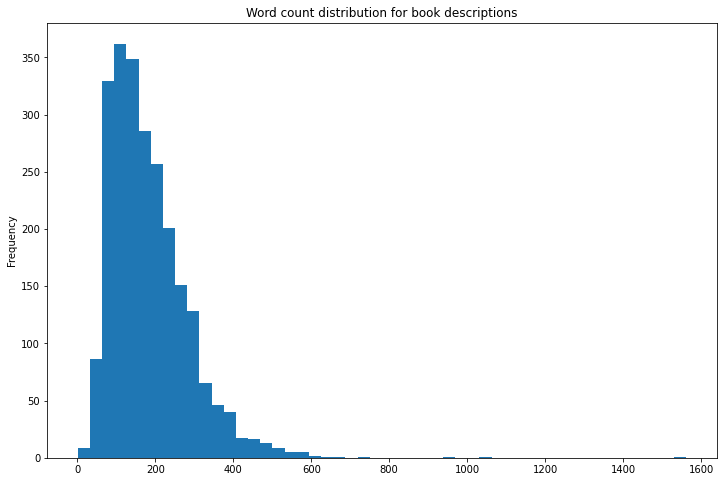

In [47]:
books["word_count"] = books['Desc'].apply(lambda x: len(str(x).split()))

books['word_count'].plot(
    kind="hist",
    bins=50,
    figsize = (12, 8),
    title="Word count distribution for book descriptions"
)

       word  pos
0         0   CD
1        We  PRP
2      know  VBP
3      that   DT
4     power   NN
..      ...  ...
98     Desc  NNP
99   Length  NNP
100    2382   CD
101   dtype   NN
102  object   NN

[103 rows x 2 columns]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\konar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\konar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<AxesSubplot:title={'center':'Top 20 Part-of-speech tagging for comments'}>

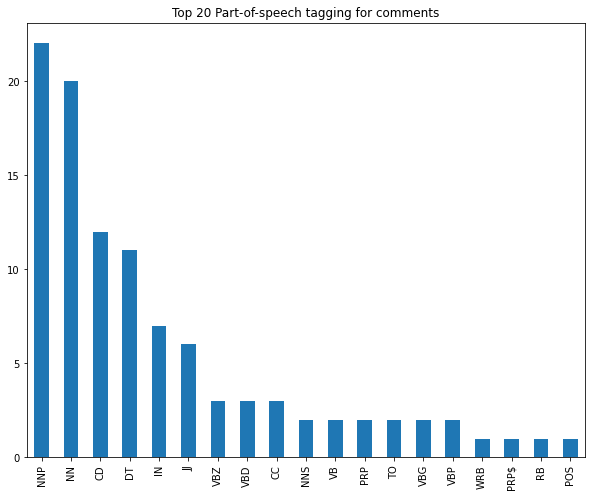

In [48]:
from textblob import TextBlob
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

blob = TextBlob(str(books['Desc']))
pos_books = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
print(pos_books)
pos_books = pos_books.pos.value_counts()[:20]
pos_books.plot(kind = 'bar', figsize=(10, 8), title = "Top 20 Part-of-speech tagging for comments")

<AxesSubplot:title={'center':'Bigram disribution for the top 20 words in the book description'}, xlabel='bigram'>

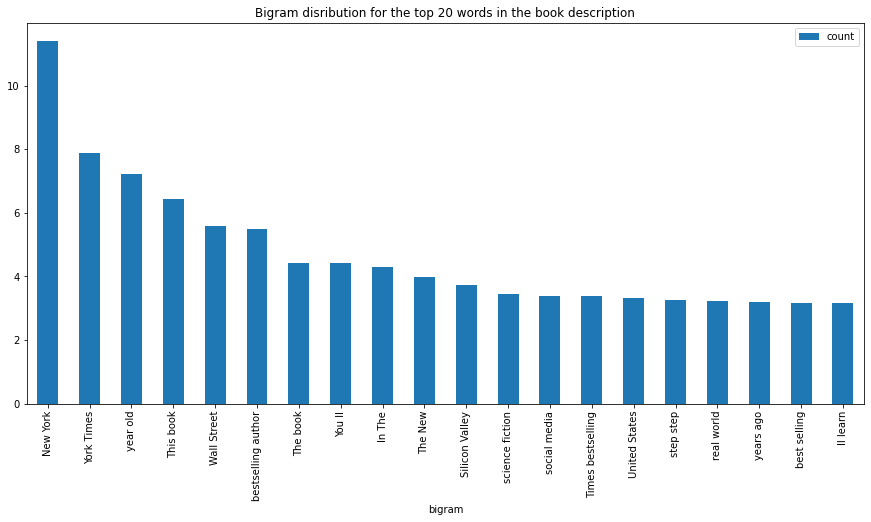

In [49]:
# Converting text descriptions into vectors using TF-IDF using Bigram
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(books['Desc'])
total_words = tfidf_matrix.sum(axis=0) 

#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)

#converting into dataframe 
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 

#Taking first 20 records
bigram = bigram.head(20)

#Plotting the bigram distribution
bigram.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the book description", figsize = (15,7), )

<AxesSubplot:title={'center':'Bigram disribution for the top 20 words in the book description'}, xlabel='trigram'>

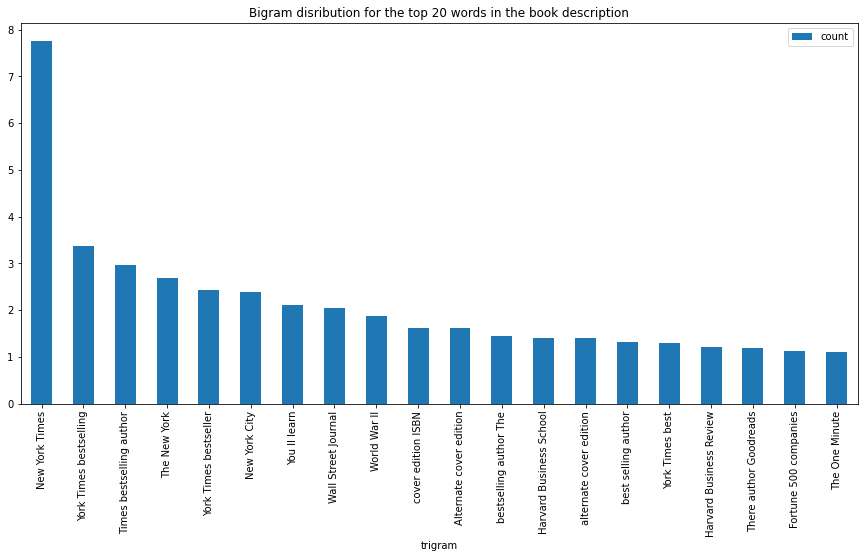

In [50]:
#Converting text descriptions into vectors using TF-IDF using Trigram
tf = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(books['Desc'])
total_words = tfidf_matrix.sum(axis=0) 

#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)

#converting into dataframe 
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True) 

#Taking first 20 records
trigram = trigram.head(20)

#Plotting the trigramn distribution
trigram.plot(x ='trigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the book description", figsize = (15,7), )

In [51]:
nltk.download('stopwords')

# Function for removing NonAscii characters
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Function for converting into lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

#Function for removing the html tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Applying all the functions in description and storing as a cleaned_desc
books['cleaned_desc'] = books['Desc'].apply(_removeNonAscii)
books['cleaned_desc'] = books.cleaned_desc.apply(func = make_lower_case)
books['cleaned_desc'] = books.cleaned_desc.apply(func = remove_stop_words)
books['cleaned_desc'] = books.cleaned_desc.apply(func=remove_punctuation)
books['cleaned_desc'] = books.cleaned_desc.apply(func=remove_html)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\konar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
# Function for recommending books based on Book title. It takes book title and genre as an input.
def recommendByTitle(title, genre):
    
    # Matching the genre with the dataset and reset the index
    data = books.loc[books['genre'] == genre]  
    data.reset_index(level = 0, inplace = True) 
  
    # Convert the index into series
    indices = pd.Series(data.index, index = data['title'])
    
    #Converting the book title into vectors and used bigram
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['title'])
    
    # Calculating the similarity measures based on Cosine Similarity
    sg = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Get the index corresponding to original_title
       
    idx = indices[title]
    # Get the pairwsie similarity scores 
    sig = list(enumerate(sg[idx]))
    
    # Sort the books
    sig = sorted(sig, key=lambda x: x[1], reverse=True)
    
    # Scores of the 5 most similar books 
    sig = sig[1:6]
    
    # Book indicies
    movie_indices = [i[0] for i in sig]
   
    # Top 5 book recommendation
    rec = data[['title', 'url']].iloc[movie_indices]
       
    # It reads the top 5 recommend book
    
    print("TOP 5 Recommended Books are... \n")
    
    index = 1
    for i in movie_indices:
        title = rec['title'][i]
        print(index ," ", title)
        index += 1

In [53]:
recommendByTitle("Harry Potter and the Order of the Phoenix", "Non-Fiction")

TOP 5 Recommended Books are... 

1   Harry Potter and the Goblet of Fire
2   Harry Potter and the Sorcerer's Stone
3   Harry Potter and the Chamber of Secrets
4   Harry Potter and the Prisoner of Azkaban
5   Harry Potter and the Deathly Hallows


In [54]:
# Function for recommending books based on Book title. It takes book title and genre as an input.
def recommendByDesc(title, genre):
    
    # Matching the genre with the dataset and reset the index
    data = books.loc[books['genre'] == genre]  
    data.reset_index(level = 0, inplace = True) 
  
    # Convert the index into series
    indices = pd.Series(data.index, index = data['title'])
    
    #Converting the book description into vectors and used bigram
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['cleaned_desc'])
    
    # Calculating the similarity measures based on Cosine Similarity
    sg = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Get the index corresponding to original_title
       
    idx = indices[title]
    
    # Get the pairwsie similarity scores 
    sig = list(enumerate(sg[idx]))
    
    # Sort the books
    sig = sorted(sig, key=lambda x: x[1], reverse=True)
    
    # Scores of the 5 most similar books 
    sig = sig[1:6]
    
    # Book indicies
    movie_indices = [i[0] for i in sig]
   
    # Top 5 book recommendation
    rec = data[['title', 'url']].iloc[movie_indices]
    
    # It reads the top 5 recommend
    
    print("TOP 5 Recommended Books are... \n")
    
    index = 1
    for i in movie_indices:
        title = rec['title'][i]
        print(index ," ", title)
        index += 1

In [55]:
recommendByDesc("Harry Potter and the Prisoner of Azkaban", "Non-Fiction")

TOP 5 Recommended Books are... 

1   Harry Potter and the Sorcerer's Stone
2   Harry Potter and the Order of the Phoenix
3   Harry Potter and the Chamber of Secrets
4   Harry Potter and the Cursed Child: Parts One and Two
5   Fantastic Beasts and Where to Find Them


In [57]:
pickle.dump(books, open('../server/models/books.pkl', 'wb'))
pickle.dump(cosine_similarity, open('../server/models/cosine_similarity.pkl', 'wb'))